# This is our workspace for data analysis!

In [88]:
# feel free to add more
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import statsmodels.api as sm

In [89]:
# Create connection to atlas
conn_atlas = sqlite3.connect('./atlas.db')
c_atlas = conn_atlas.cursor()

In [90]:
LIST_TABLES_CMD = "SELECT name FROM sqlite_master WHERE type='table';"

# You can switch this to any table
LIST_COLUMNS_CMD_ATLAS = "PRAGMA table_info('acs2015_county_data');"

c_atlas.execute(LIST_TABLES_CMD)
conn_atlas.commit()

for row in c_atlas:
  print(row)

c_atlas.execute(LIST_COLUMNS_CMD_ATLAS)
conn_atlas.commit()

for column in c_atlas:
    print(column)

('Atlas_of_Surveillance_20201007',)
('acs2017_county_data',)
('acs2015_county_data',)
(0, 'CountyId', 'TEXT', 0, None, 0)
(1, 'State', 'TEXT', 0, None, 0)
(2, 'County', 'TEXT', 0, None, 0)
(3, 'TotalPop', 'TEXT', 0, None, 0)
(4, 'Men', 'TEXT', 0, None, 0)
(5, 'Women', 'TEXT', 0, None, 0)
(6, 'Hispanic', 'TEXT', 0, None, 0)
(7, 'White', 'TEXT', 0, None, 0)
(8, 'Black', 'TEXT', 0, None, 0)
(9, 'Native', 'TEXT', 0, None, 0)
(10, 'Asian', 'TEXT', 0, None, 0)
(11, 'Pacific', 'TEXT', 0, None, 0)
(12, 'VotingAgeCitizen', 'TEXT', 0, None, 0)
(13, 'Income', 'TEXT', 0, None, 0)
(14, 'IncomeErr', 'TEXT', 0, None, 0)
(15, 'IncomePerCap', 'TEXT', 0, None, 0)
(16, 'IncomePerCapErr', 'TEXT', 0, None, 0)
(17, 'Poverty', 'TEXT', 0, None, 0)
(18, 'ChildPoverty', 'TEXT', 0, None, 0)
(19, 'Professional', 'TEXT', 0, None, 0)
(20, 'Service', 'TEXT', 0, None, 0)
(21, 'Office', 'TEXT', 0, None, 0)
(22, 'Construction', 'TEXT', 0, None, 0)
(23, 'Production', 'TEXT', 0, None, 0)
(24, 'Drive', 'TEXT', 0, None, 0)

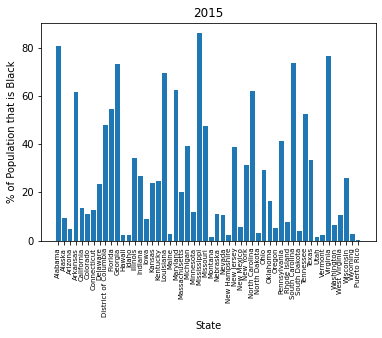

In [91]:
# Feel free to change to demographic groups
cursor_2015_black = conn_atlas.cursor()
SELECT_BLACK_2015 = "SELECT Black from acs2015_county_data"
cursor_2015_black.execute(SELECT_BLACK_2015)

cursor_2015_state = conn_atlas.cursor()
SELECT_STATE_2015 = "SELECT State from acs2015_county_data"
cursor_2015_state.execute(SELECT_STATE_2015)
black_2015 = [float(a[0]) for a in cursor_2015_black]
state_2015 = [a[0] for a in cursor_2015_state]

plot_state_race = plt.bar(state_2015, black_2015)
plt.title('2015')
plt.xlabel('State')
plt.ylabel('% of Population that is Black')
plt.xticks(fontsize=7, rotation=90)
plt.show()

# OLS workspace
- array with number of each race in a county (multiply percentage by total pop)
- array with total number of surveillance devices in a county (need SQL query for this)
    - SQL query to join 

In [92]:
# Number of black people in each county
# black_2015

# Feel free to change to demographic groups
cursor_2015_total_pop = conn_atlas.cursor()
SELECT_TOTAL_POP_2015 = "SELECT TotalPop from acs2015_county_data"
cursor_2015_total_pop.execute(SELECT_TOTAL_POP_2015)
total_pop_2015 = [float(a[0]) for a in cursor_2015_total_pop]
total_pop_black_2015 = []
for i in range(len(total_pop_2015)) :
    total_pop_black_2015.append(total_pop_2015[i] * black_2015[i])

In [93]:
# select *
# from Db1.dbo.Clients c
# join Db2.dbo.Messages m on c.ClientId = m.ClientId


COUNT_QUERY = 'SELECT * FROM acs2015_county_data INNER JOIN Atlas_of_Surveillance_20201007 ON acs2015_county_data.County = Atlas_of_Surveillance_20201007.County'


JOIN_QUERY = 'SELECT acs2015_county_data.Black, acs2015_county_data.TotalPop, (Atlas_of_surveillance_20201007.State || \' \' || Atlas_of_Surveillance_20201007.County), acs2015_county_data.Poverty FROM Atlas_of_Surveillance_20201007, acs2015_county_data WHERE (acs2015_county_data.State || acs2015_county_data.County) = (Atlas_of_Surveillance_20201007.State || Atlas_of_Surveillance_20201007.County);'
c_atlas = conn_atlas.cursor()
c_atlas.execute(JOIN_QUERY)
conn_atlas.commit()

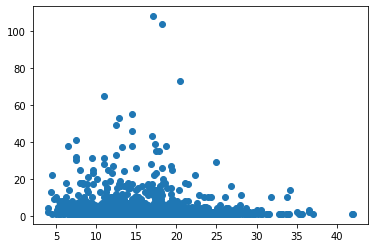

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     13.57
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           0.000240
Time:                        18:56:32   Log-Likelihood:                -4456.7
No. Observations:                1288   AIC:                             8917.
Df Residuals:                    1286   BIC:                             8928.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3591      0.618     10.286      0.0

In [94]:
# x should be number of a demographic group per county
# y should be number of cameras found

# map of county -> number of cameras in that county
cameras_per_county = collections.Counter([row[2] for row in c_atlas])

# map of county -> percentage of Black people in that county
pop_black = {}
cameras_per_capita = {}
c_atlas = conn_atlas.cursor()
c_atlas.execute(JOIN_QUERY)
conn_atlas.commit()
poverty_per_capita = {}
for row in c_atlas :
    percent_black, total_pop, county_state, poverty = row
    pop_black[county_state] = float(percent_black)
    cameras_per_capita[county_state] = float(cameras_per_county[county_state]) # / float(total_pop)
    poverty_per_capita[county_state] = float(poverty)
x = []
y = []
for county_state in cameras_per_capita :
    y.append(cameras_per_capita[county_state])
    x.append(poverty_per_capita[county_state])
x, y = np.array(x), np.array(y)
plt.scatter(x, y)
plt.show()
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

# KNN Workspace

In [132]:
ML_DATA_QUERY = '''
                SELECT 
                    (Atlas_of_surveillance_20201007.State || \' \' || Atlas_of_Surveillance_20201007.County),
                    acs2015_county_data.Black, 
                    acs2015_county_data.TotalPop, 
                    acs2015_county_data.Poverty,
                    acs2015_county_data.Men,
                    acs2015_county_data.Women,
                    acs2015_county_data.White,
                    acs2015_county_data.Native,
                    acs2015_county_data.Hispanic,
                    acs2015_county_data.Asian,
                    acs2015_county_data.Pacific,
                    acs2015_county_data.Income,
                    acs2015_county_data.Drive,
                    acs2015_county_data.Walk,
                    acs2015_county_data.Transit,
                    acs2015_county_data.Professional,
                    acs2015_county_data.WorkAtHome,
                    acs2015_county_data.Unemployment,
                    acs2015_county_data.SelfEmployed,
                    acs2015_county_data.Professional,
                    acs2015_county_data.Employed
                FROM Atlas_of_Surveillance_20201007, acs2015_county_data
                WHERE (acs2015_county_data.State || acs2015_county_data.County) = (Atlas_of_Surveillance_20201007.State || Atlas_of_Surveillance_20201007.County);'''

c_atlas = conn_atlas.cursor()
c_atlas.execute(ML_DATA_QUERY)
conn_atlas.commit()


# dictionary going from County_state -> numpy array of features for that county_state -> numpy 2d array
features_map = {}
cameras_per_county = collections.Counter([row[0] for row in c_atlas])
c_atlas = conn_atlas.cursor()
c_atlas.execute(ML_DATA_QUERY)
conn_atlas.commit()
nums = []
for val in cameras_per_county.values() :
    nums.append(float(val))
a = np.percentile(np.array(nums), 25, axis=None, out=None)
b = np.percentile(np.array(nums), 50, axis=None, out=None)
c = np.percentile(np.array(nums), 75, axis=None, out=None)
d = np.percentile(np.array(nums), 100, axis=None, out=None)

for row in c_atlas :
    county = row[0]
    features_map[county] = np.asarray(row[1:len(row)], dtype=np.float32)
#print(len(cameras_per_county), len(features_map))

# print(cameras_per_county, features_map)
# store the feature matrix (X) and response vector (y) 
# 2d numpy array of features (feature matrix)



Counter({'Illinois Peoria County': 3.0, 'New York Monroe County': 3.0, 'Pennsylvania Allegheny County': 3.0, 'New York Orange County': 3.0, 'Georgia Fayette County': 3.0, 'Florida Marion County': 3.0, 'New Mexico Santa Fe County': 3.0, 'New York Westchester County': 3.0, 'Alabama Madison County': 3.0, 'North Carolina Pitt County': 3.0, 'Texas Lubbock County': 3.0, 'Ohio Stark County': 3.0, 'Pennsylvania Lehigh County': 3.0, 'Ohio Lucas County': 3.0, 'Indiana Lake County': 3.0, 'Florida Miami-Dade County': 3.0, 'Texas Bell County': 3.0, 'Illinois Cook County': 3.0, 'Ohio Lorain County': 3.0, 'New Jersey Monmouth County': 3.0, 'New York Dutchess County': 3.0, 'Colorado Pueblo County': 3.0, 'Wisconsin Jefferson County': 3.0, 'Florida Leon County': 3.0, 'New Jersey Camden County': 3.0, 'New Jersey Passaic County': 3.0, 'Florida Polk County': 3.0, 'Florida Manatee County': 3.0, 'Florida Pasco County': 3.0, 'Florida Pinellas County': 3.0, 'Florida Sarasota County': 3.0, 'Texas Guadalupe Coun

0.5852713178294574
0.5813953488372093
0.562015503875969
0.5736434108527132
0.5736434108527132
0.5697674418604651
0.562015503875969
0.5697674418604651
0.5658914728682171
0.5697674418604651
0.5697674418604651
0.5736434108527132
0.5697674418604651
0.5697674418604651
0.5697674418604651
0.5658914728682171
0.5503875968992248
0.5697674418604651
0.562015503875969
0.5697674418604651
0.5658914728682171
0.5542635658914729
0.562015503875969
0.5736434108527132
0.5736434108527132
0.5697674418604651
0.5736434108527132
0.5697674418604651
0.5736434108527132
0.5813953488372093
0.5736434108527132
0.5697674418604651
0.5852713178294574
0.5813953488372093
0.5775193798449613
0.5736434108527132
0.5775193798449613
0.5775193798449613
0.5736434108527132
0.5736434108527132
0.5775193798449613
0.5813953488372093
0.5775193798449613
0.5813953488372093
0.5775193798449613
0.5813953488372093
0.5930232558139535
0.5852713178294574
0.5813953488372093
0.5813953488372093
0.5852713178294574
0.5775193798449613
0.57751937984496

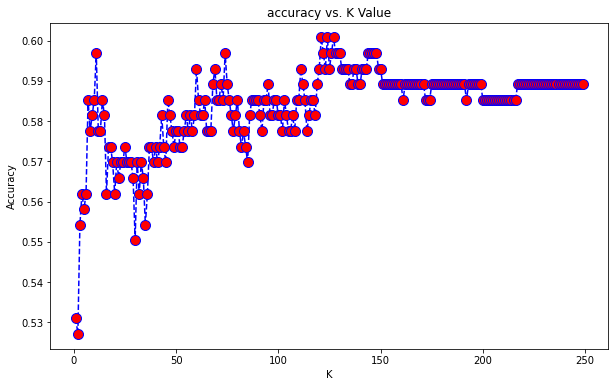

In [133]:
for county in cameras_per_county :
    num_cams = cameras_per_county[county]
    if num_cams <= a :
        cameras_per_county[county] = 0.0
    elif num_cams <= b :
        cameras_per_county[county] = 1.0
    elif num_cams <= c :
        cameras_per_county[county] = 2.0
    elif num_cams <= d :
        cameras_per_county[county] = 3.0
print(cameras_per_county)
X = []

# labels
y = []
for county in cameras_per_county :
    X.append(features_map[county])
    y.append(cameras_per_county[county])

X = np.array(X)
y = np.array(y)
    
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics 
# knn = KNeighborsClassifier(n_neighbors=5) 
# knn.fit(X_train, y_train) 

accuracies = []
for i in range(1, 250):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    acc = metrics.accuracy_score(y_test, pred_i)
    accuracies.append(acc)
    print(acc)
print(max(accuracies))

plt.figure(figsize=(10,6))
plt.plot(range(1,250),accuracies,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

print(len(set(y_test)))

# y_pred = knn.predict(X_test) 
# print("kNN model accuracy:", metrics.accuracy_score(y_test, y_pred)) 